In [1]:
# Import standard modules.
from importlib import import_module
import os
import sys

# Import supplemental modules.
import matplotlib.pyplot as plt
import numpy as np

# Import project modules.
import pinn.standard_plots as psp

In [3]:
# Specify the run ID (aka problem name).
runid = "linecurrent_BxBy"

# Add the subdirectory for the run results to the module search path.
run_path = os.path.join(".", runid)
sys.path.append(run_path)

# Import the problem definition from the run results directory.
p = import_module(runid)

# Extract indices for independent and dependent variables.
it = p.independent_variable_index["t"]
ix = p.independent_variable_index["x"]
iy = p.independent_variable_index["y"]
iBx = p.dependent_variable_index["Bx"]
iBy = p.dependent_variable_index["By"]

# Read the run hyperparameters from the run results directory.
import hyperparameters as hp

In [4]:
# Define analytical solutions.

# Constants
mu0 = 1.0  # Normalized vacuum permittivity
I = 1e-3   # Normalized current
Q = 60.0   # Flow angle in degrees clockwise from +y axis
u0 = 1.0   # Initial flow speed

# Compute the constant velocity components.
u0x = u0*np.sin(np.radians(Q))
u0y = u0*np.cos(np.radians(Q))

# Leading constant in analytical solutions.
C1 = mu0*I/(2*np.pi)


def Bx_analytical(t, x, y):
    r = np.sqrt((x - u0x*t)**2 + (y - u0y*t)**2)
    Bx = -C1*(y - u0y*t)/r**2
    return Bx

def By_analytical(t, x, y):
    r = np.sqrt((x - u0x*t)**2 + (y - u0y*t)**2)
    By = C1*(x - u0x*t)/r**2
    return By

def dBx_dx_analytical(t, x, y):
    r = np.sqrt((x - u0x*t)**2 + (y - u0y*t)**2)
    dBx_dx = 2*C1*(x - u0x*t)*(y - u0y*t)/r**4
    return dBx_dx

def dBy_dy_analytical(t, x, y):
    r = np.sqrt((x - u0x*t)**2 + (y - u0y*t)**2)
    dBy_dy = -2*C1*(x - u0x*t)*(y - u0y*t)/r**4
    return dBy_dy

In [5]:
# Load all data.

# Load the training point coordinates.
txy_train = np.loadtxt(os.path.join(runid, "X_train.dat"))
t_train = txy_train[:, it]
x_train = txy_train[:, ix]
y_train = txy_train[:, iy]

# Load the data locations and values (includes initial conditions).
txy_data = np.loadtxt(os.path.join(runid, "XY_data.dat"))

# Extract the initial conditions.
ic = txy_data[:, p.n_dim:]

# Load the model-predicted values.
ψ = []
delψ = []
for var_name in p.dependent_variable_names:
    ψ.append(np.loadtxt(os.path.join(runid, "%s_train.dat" % var_name)))
    delψ.append(np.loadtxt(os.path.join(runid, "del_%s_train.dat" % var_name)))

# Load the loss function histories.
losses_model = np.loadtxt(os.path.join(runid, "losses_model.dat"))
losses_model_res = np.loadtxt(os.path.join(runid, "losses_model_res.dat"))
losses_model_data = np.loadtxt(os.path.join(runid, "losses_model_data.dat"))
losses = np.loadtxt(os.path.join(runid, "losses.dat"))
losses_res = np.loadtxt(os.path.join(runid, "losses_res.dat"))
losses_data = np.loadtxt(os.path.join(runid, "losses_data.dat"))

In [6]:
# Compute the limits of the training domain.
t_min = t_train[0]
t_max = t_train[-1]
x_min = x_train[0]
x_max = x_train[-1]
y_min = y_train[0]
y_max = y_train[-1]

# Extract the unique training point values (a grid is assumed).
t_train_vals = np.unique(t_train)
x_train_vals = np.unique(x_train)
y_train_vals = np.unique(y_train)
n_t_train_vals = len(t_train_vals)
n_x_train_vals = len(x_train_vals)
n_y_train_vals = len(y_train_vals)

In [8]:
# Plotting options

# Specify the size (width, height) (in inches) for individual subplots.
SUBPLOT_WIDTH = 5.0
SUBPLOT_HEIGHT = 5.0

# Compute the figure size for the total loss plot.
total_loss_figsize = (SUBPLOT_WIDTH*2, SUBPLOT_HEIGHT)

# Compute the coordinate plot tick locations and labels.
XY_N_X_TICKS = 5
XY_x_tick_pos = np.linspace(x_min, x_max, XY_N_X_TICKS)
XY_x_tick_labels = ["%.1f" % x for x in XY_x_tick_pos]
XY_N_Y_TICKS = 5
XY_y_tick_pos = np.linspace(y_min, y_max, XY_N_Y_TICKS)
XY_y_tick_labels = ["%.1f" % y for y in XY_y_tick_pos]

# Compute the heat map tick locations and labels.
HEATMAP_N_X_TICKS = 5
heatmap_x_tick_pos = np.linspace(0, n_x_train_vals - 1, HEATMAP_N_X_TICKS)
heatmap_x_tick_labels = ["%.1f" % (x_min + x/(n_x_train_vals - 1)*(x_max - x_min)) for x in heatmap_x_tick_pos]
HEATMAP_N_Y_TICKS = 5
heatmap_y_tick_pos = np.linspace(0, n_y_train_vals - 1, HEATMAP_N_Y_TICKS)
heatmap_y_tick_labels = ["%.1f" % (y_min + y/(n_y_train_vals - 1)*(y_max - y_min)) for y in heatmap_y_tick_pos]
heatmap_y_tick_labels = list(reversed(heatmap_y_tick_labels))

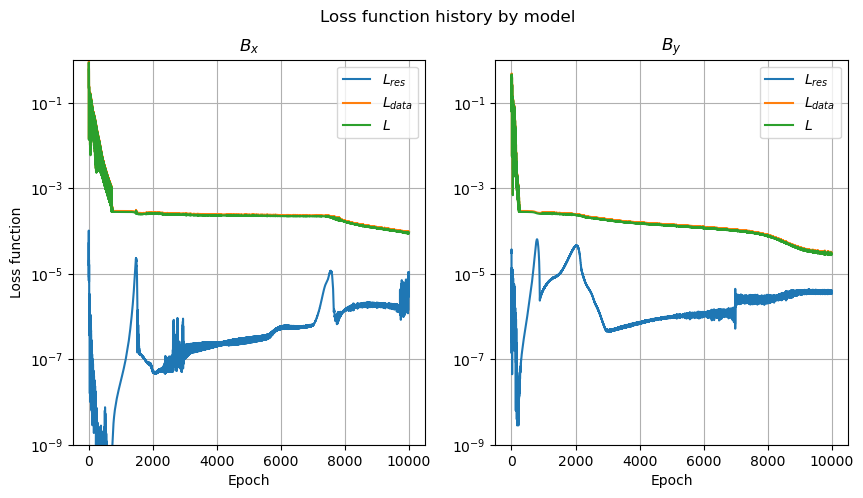

In [9]:
# Plot the loss history for each model.
fig = psp.plot_model_loss_functions(
    losses_model_res, losses_model_data, losses_model,
    p.dependent_variable_labels
)

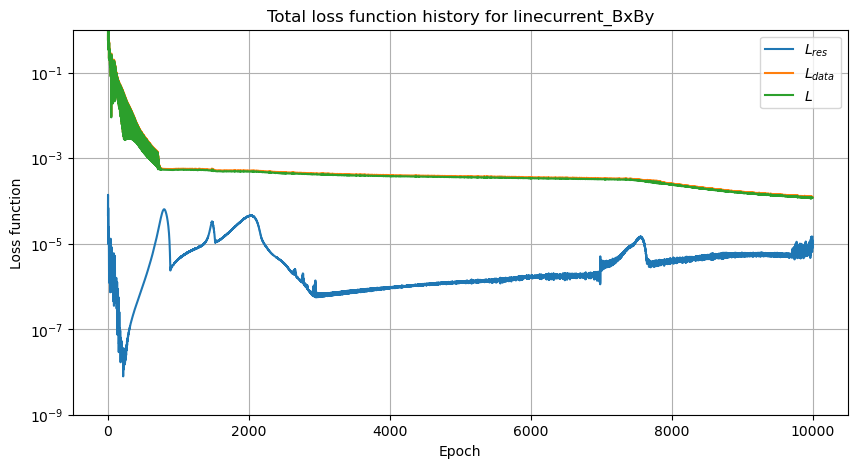

In [10]:
# Plot the total loss function history.
plt.figure(figsize=total_loss_figsize)
psp.plot_loss_functions(
    [losses_res, losses_data, losses],
    ["$L_{res}$", "$L_{data}$", "$L$"],
    title="Total loss function history for %s" % runid
)

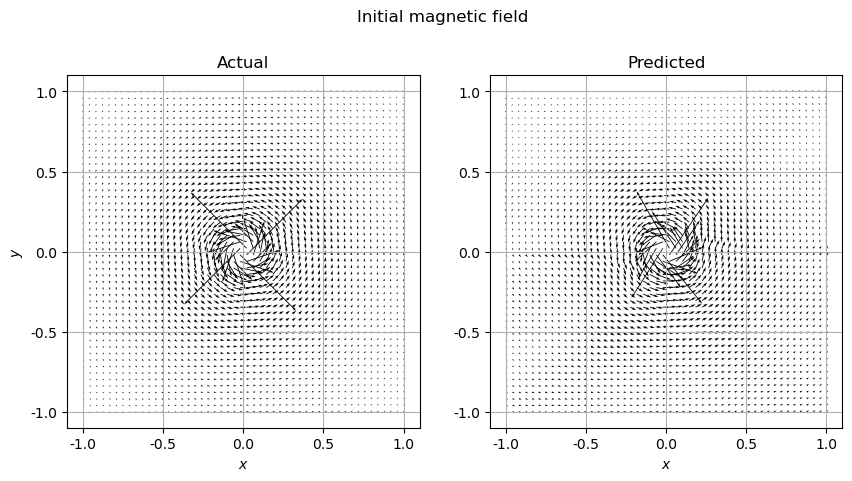

In [11]:
# Plot the actual and predicted initial magnetic field vectors.
n_start = n_x_train_vals*n_y_train_vals
t = txy_data[:, it]
x = txy_data[:, ix]
y = txy_data[:, iy]
B0x_act = Bx_analytical(t, x, y)
B0y_act = By_analytical(t, x, y)
B0x_pred = ψ[iBx][:n_start]
B0y_pred = ψ[iBy][:n_start]

# Create the figure.
fig = psp.plot_actual_predicted_B(
    x, y, B0x_act, B0y_act, B0x_pred, B0y_pred,
    title="Initial magnetic field",
    x_tick_pos=XY_x_tick_pos, x_tick_labels=XY_x_tick_labels,
    y_tick_pos=XY_y_tick_pos, y_tick_labels=XY_y_tick_labels,
)

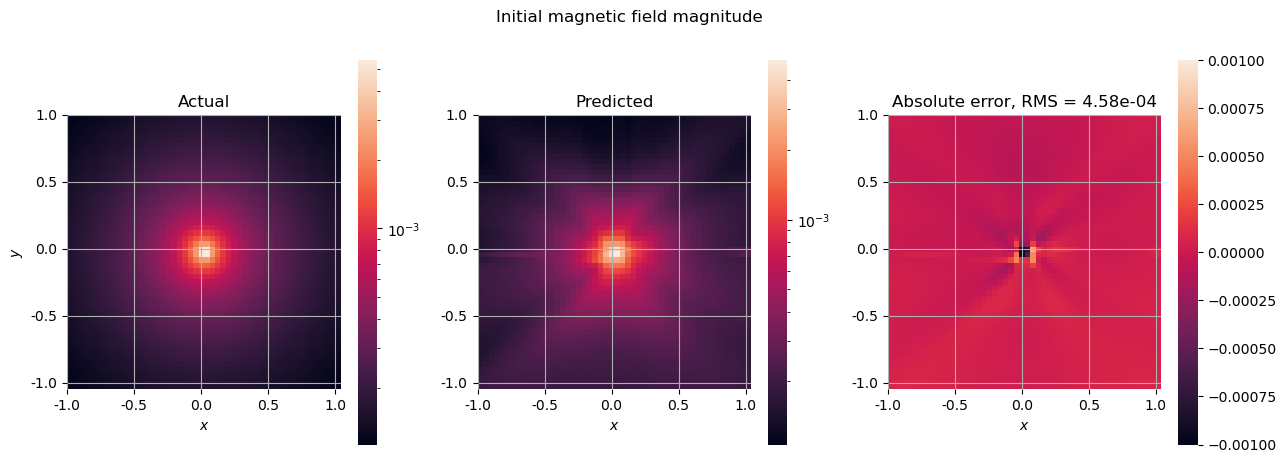

In [12]:
# Plot the actual, predicted, and absolute errors in initial magnetic field magnitudes.
B0_act = np.sqrt(B0x_act**2 + B0y_act**2)
B0_pred = np.sqrt(B0x_pred**2 + B0y_pred**2)
B0_err = B0_pred - B0_act

# To get the proper orientation, reshape, transpose, flip.
B0_act_plot = np.flip(B0_act.reshape(n_x_train_vals, n_y_train_vals).T, axis=0)
B0_pred_plot = np.flip(B0_pred.reshape(n_x_train_vals, n_y_train_vals).T, axis=0)
B0_err_plot = np.flip(B0_err.reshape(n_x_train_vals, n_y_train_vals).T, axis=0)

# Create the plot.
fig = psp.plot_log_actual_predicted_error(
    x, y, B0_act_plot, B0_pred_plot, B0_err_plot,
    vmin=1e-6, vmax=1, err_vmin=-1e-3, err_vmax=1e-3,
    title="Initial magnetic field magnitude",
    x_tick_pos=heatmap_x_tick_pos, x_tick_labels=heatmap_x_tick_labels,
    y_tick_pos=heatmap_y_tick_pos, y_tick_labels=heatmap_y_tick_labels,
)

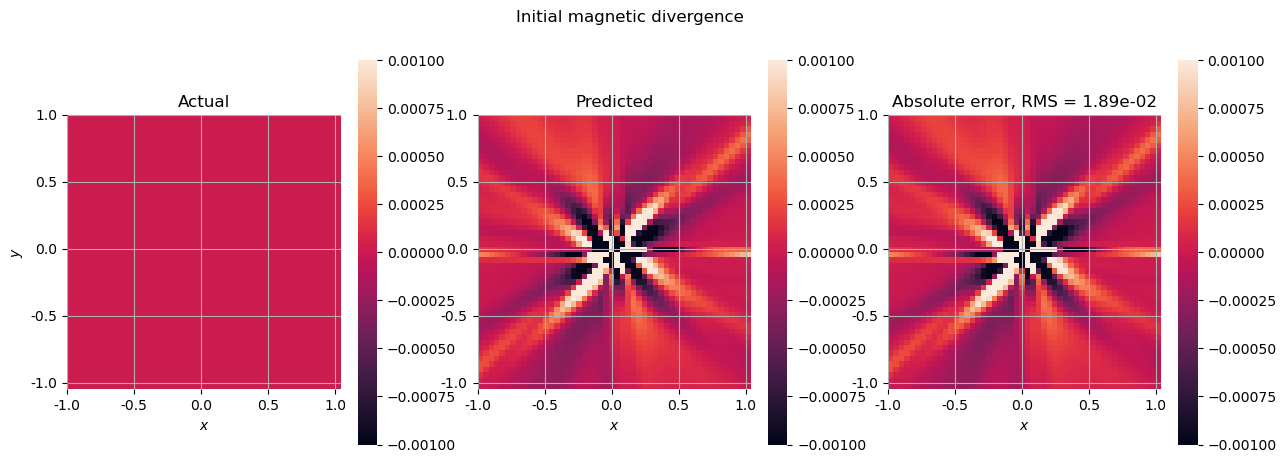

In [13]:
# Plot the actual, predicted, and absolute errors in initial magnetic field divergence.
dB0x_dx_act = dBx_dx_analytical(t, x, y)
dB0y_dy_act = dBy_dy_analytical(t, x, y)
divB0_act = dB0x_dx_act + dB0y_dy_act
dB0x_dx_pred = delψ[iBx][:n_start, 1]
dB0y_dy_pred = delψ[iBy][:n_start, 2]
divB0_pred = dB0x_dx_pred + dB0y_dy_pred
divB0_err = divB0_pred - divB0_act

# To get the proper orientation, reshape, transpose, flip.
divB0_act_plot = np.flip(divB0_act.reshape(n_x_train_vals, n_y_train_vals).T, axis=0)
divB0_pred_plot = np.flip(divB0_pred.reshape(n_x_train_vals, n_y_train_vals).T, axis=0)
divB0_err_plot = np.flip(divB0_err.reshape(n_x_train_vals, n_y_train_vals).T, axis=0)

# Create the figure.
fig = psp.plot_actual_predicted_error(
    x, y, divB0_act_plot, divB0_pred_plot, divB0_err_plot,
    vmin=-1e-3, vmax=1e-3, err_vmin=-1e-3, err_vmax=1e-3,
    title="Initial magnetic divergence",
    x_tick_pos=heatmap_x_tick_pos, x_tick_labels=heatmap_x_tick_labels,
    y_tick_pos=heatmap_y_tick_pos, y_tick_labels=heatmap_y_tick_labels,
)

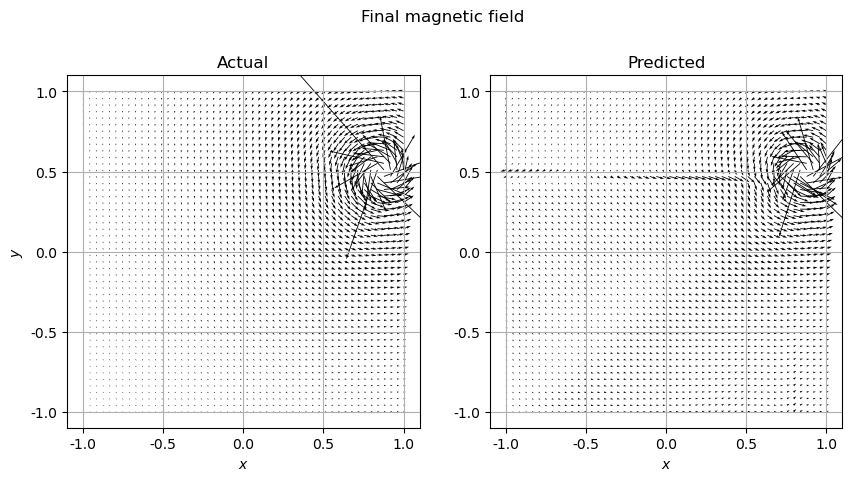

In [14]:
# Plot the actual and predicted final magnetic field vectors.
n_end = n_x_train_vals*n_y_train_vals
t = t_train[-n_end:]
x = x_train[-n_end:]
y = y_train[-n_end:]
B1x_act = Bx_analytical(t, x, y)
B1y_act = By_analytical(t, x, y)
B1x_pred = ψ[iBx][-n_end:]
B1y_pred = ψ[iBy][-n_end:]

# Create the figure.
fig = psp.plot_actual_predicted_B(
    x, y, B1x_act, B1y_act, B1x_pred, B1y_pred,
    title="Final magnetic field",
    x_tick_pos=XY_x_tick_pos, x_tick_labels=XY_x_tick_labels,
    y_tick_pos=XY_y_tick_pos, y_tick_labels=XY_y_tick_labels,
)

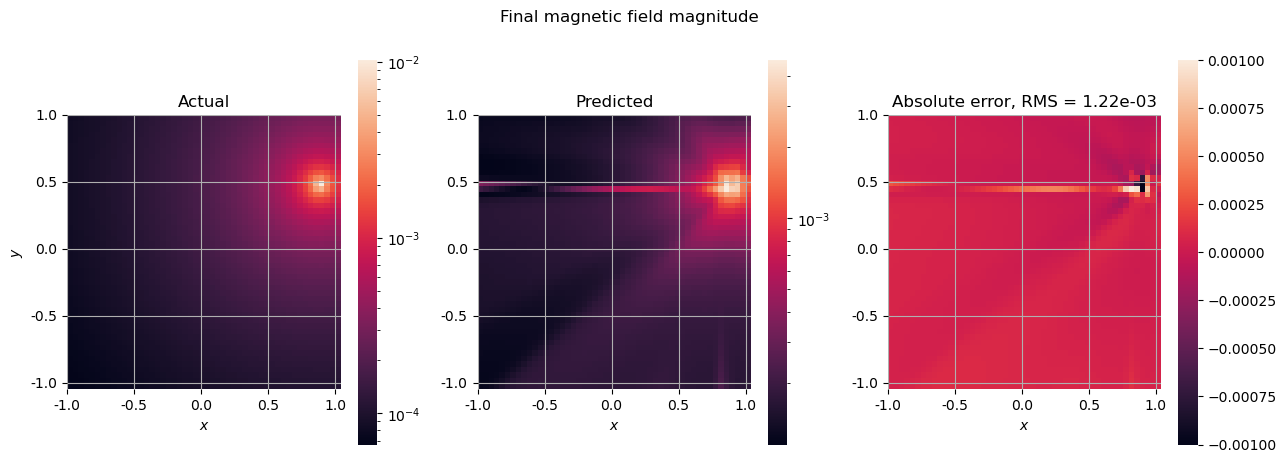

In [15]:
# Plot the actual, predicted, and errors in final magnetic field magnitudes.
B1_act = np.sqrt(B1x_act**2 + B1y_act**2)
B1_pred = np.sqrt(B1x_pred**2 + B1y_pred**2)
B1_err = B1_pred - B1_act

# To get the proper orientation, reshape, transpose, flip.
B1_act_plot = np.flip(B1_act.reshape(n_x_train_vals, n_y_train_vals).T, axis=0)
B1_pred_plot = np.flip(B1_pred.reshape(n_x_train_vals, n_y_train_vals).T, axis=0)
B1_err_plot = np.flip(B1_err.reshape(n_x_train_vals, n_y_train_vals).T, axis=0)

# Create the plot.
fig = psp.plot_log_actual_predicted_error(
    x, y, B1_act_plot, B1_pred_plot, B1_err_plot,
    vmin=1e-6, vmax=1, err_vmin=-1e-3, err_vmax=1e-3,
    title="Final magnetic field magnitude",
    x_tick_pos=heatmap_x_tick_pos, x_tick_labels=heatmap_x_tick_labels,
    y_tick_pos=heatmap_y_tick_pos, y_tick_labels=heatmap_y_tick_labels,
)

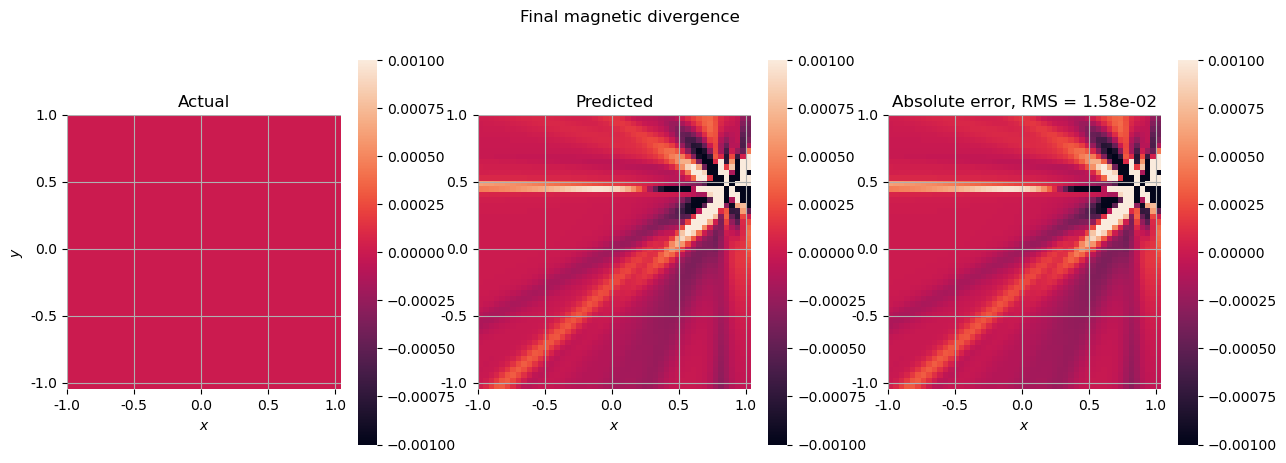

In [16]:
# Plot the actual, predicted, and errors in final magnetic field divergence.
dB1x_dx_act = dBx_dx_analytical(t, x, y)
dB1y_dy_act = dBy_dy_analytical(t, x, y)
divB1_act = dB1x_dx_act + dB1y_dy_act
dB1x_dx_pred = delψ[0][-n_end:, 1]
dB1y_dy_pred = delψ[1][-n_end:, 2]
divB1_pred = dB1x_dx_pred + dB1y_dy_pred
divB1_err = divB1_pred - divB1_act

# To get the proper orientation, reshape, transpose, flip.
divB1_act_plot = np.flip(divB1_act.reshape(n_x_train_vals, n_y_train_vals).T, axis=0)
divB1_pred_plot = np.flip(divB1_pred.reshape(n_x_train_vals, n_y_train_vals).T, axis=0)
divB1_err_plot = np.flip(divB1_err.reshape(n_x_train_vals, n_y_train_vals).T, axis=0)

# Create the figure.
fig = psp.plot_actual_predicted_error(
    x, y, divB1_act_plot, divB1_pred_plot, divB1_err_plot,
    vmin=-1e-3, vmax=1e-3, err_vmin=-1e-3, err_vmax=1e-3,
    title="Final magnetic divergence",
    x_tick_pos=heatmap_x_tick_pos, x_tick_labels=heatmap_x_tick_labels,
    y_tick_pos=heatmap_y_tick_pos, y_tick_labels=heatmap_y_tick_labels,
)